In [8]:
import math
import numpy as np
import matplotlib.pyplot as plot
%matplotlib inline

In [9]:
class Value():
    def __init__(self, data, _op='', label='', _children=()):
        self.data = data
        self._op = _op
        self.label = label
        self._prev = set(_children)
        self._backward = lambda: None
        self.grad = 0.0        
        

    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data+other.data, _op='+', _children=(self, other))
        def backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = backward
        return out

    def __mul__(self, other):
        out = Value(self.data*other.data, _op='*', _children=(self, other))
        def backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = backward

        return out

    def tanh(self):
        # tanhx = (e^2x - 1) / (e^2x + 1) = (e^x - e^-x) / (e^x + e^-x)
        # d(tanhx)/dx = 1 - tanh^2x
        x = self.data
        data = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)

        out = Value(data, _op=f'tanh({self.data})', _children=(self,))
        def backward():
          self.grad += (1 - data**2) * out.grad
        out._backward = backward
        return out    

    def exp(self):
        data = math.exp(self.data)
        out = Value(data, _op='exp', _children=(self, ))
        def backward():
          self.grad += data * out.grad
        out._backword = backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, _children=(self,), _op=f'**{other}')
    
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * other**-1
    def __rtruediv__(self, other):
        return other * self**-1
    def __rmul__(self, other):
        return self * other
    def __radd__(self, other):
        return self + other
    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        return self + (-other)

    def backward(self):
        nodes = []
        visited = set()
        def topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    topo(child)
                nodes.append(node)
        topo(self)
        
        for node in reversed(nodes):
            node._backward()
            

In [11]:
a = Value(2.); a.label='a'
b = Value(1.2); b.label='b'
c = a / b; c.label='c'
d = c + 3; d.label='d'
f = d.exp(); f.label='f'

f

Value(data=106.34267539816554)

In [12]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

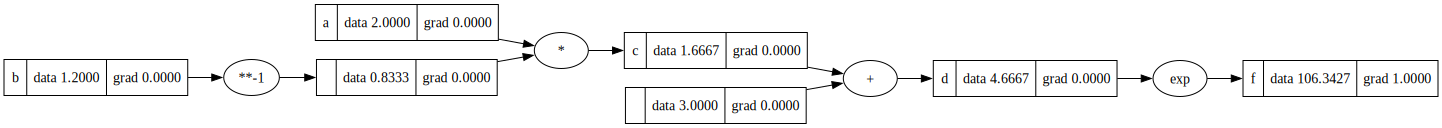

In [5]:
sorted_nodes = []
visited = set()
def topo(node):
    if node not in visited:
        visited.add(node)
        for child in node._prev:
            topo(child)
        sorted_nodes.append(node)
topo(f)
f.grad = 1
for node in reversed(sorted_nodes):
    node._backward

f.backward()

draw_dot(f)


In [13]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.grad = 1
o.backward()

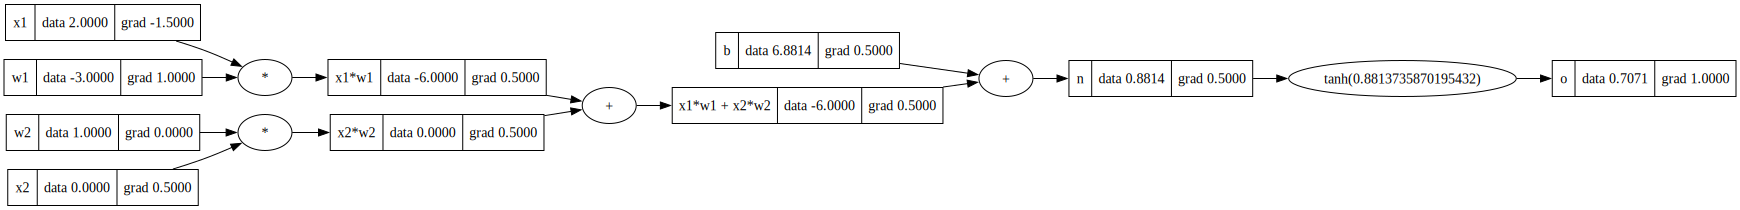

In [7]:
draw_dot(o)